In [1]:
import pandas as pd 
import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.linear_model import RidgeCV, LassoCV
from sklearn.metrics import root_mean_squared_error, r2_score

In [2]:
df = pd.read_csv('train.txt', header=None, names=['Temperature', 'Ice Cream'], sep=r'\s+')
df.head().round(2)

,Temperature,Ice Cream
0,0.00,4.46
1,0.04,3.30
2,0.08,3.60
3,0.11,3.40
4,0.15,4.57


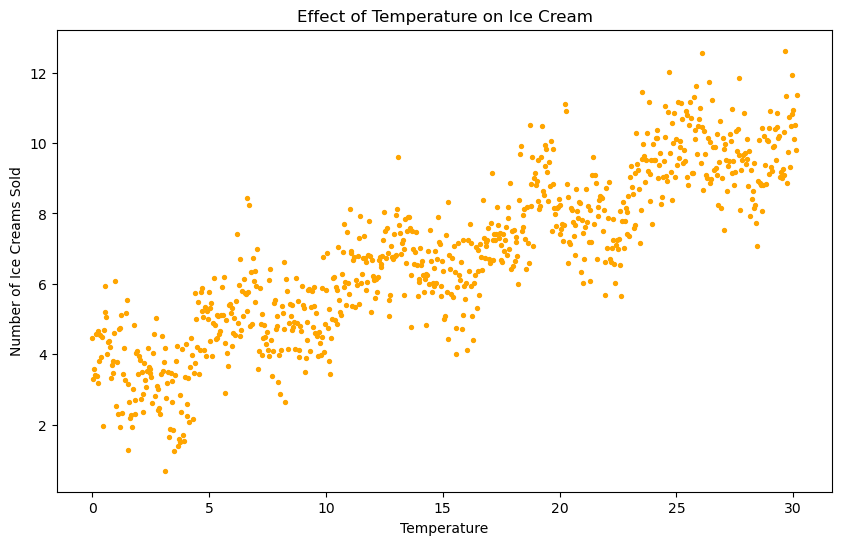

In [3]:
plt.figure(figsize=(10,6))
plt.title('Effect of Temperature on Ice Cream')
plt.scatter(x=df['Temperature'], y=df['Ice Cream'], c='orange', s=8)
plt.xlabel('Temperature')
plt.ylabel('Number of Ice Creams Sold')
plt.show()

In [4]:
model = LinearRegression()

# Converting Temperature column to DataFrame to fix reshaping issue in model.fit
X_train = pd.DataFrame(df['Temperature'])
y_train = df['Ice Cream']

model.fit(X=X_train, y=y_train)

beta_0_hat = model.intercept_
beta_1_hat = model.coef_

print(f"Estimate for β̂0: {beta_0_hat}")
print(f"Estimate for β̂1: {beta_1_hat[0]}")

Estimate for β̂0: 3.191037800253063
Estimate for β̂1: 0.23839763045936452


In [5]:
X_train = sm.add_constant(X_train)

ice_creams = sm.OLS(y_train, X_train).fit()
results = ice_creams.summary()
print(results)

                            OLS Regression Results                            
Dep. Variable:              Ice Cream   R-squared:                       0.781
Model:                            OLS   Adj. R-squared:                  0.780
Method:                 Least Squares   F-statistic:                     2840.
Date:                Fri, 01 Nov 2024   Prob (F-statistic):          4.30e-265
Time:                        17:59:46   Log-Likelihood:                -1212.4
No. Observations:                 800   AIC:                             2429.
Df Residuals:                     798   BIC:                             2438.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           3.1910      0.078     40.962      

In [6]:
def add_non_linear_features(df):
    non_linear_df = df.copy()
    epsilon = 1e-8
    non_linear_df['cos(x)'] = np.cos(df.iloc[:,0])
    non_linear_df['log(x)'] = np.log(df.iloc[:,0] + epsilon)
    non_linear_df['cos(4x)'] = np.cos(4 * df.iloc[:,0])
    non_linear_df['sin(3x)'] = np.sin(3 * df.iloc[:,0])
    non_linear_df['sin(5x)'] = np.sin(5 * df.iloc[:,0])
    non_linear_df['sin(2x)cos(2x)'] = np.sin(2 * df.iloc[:,0]) * np.cos(2 * df.iloc[:,0])

    non_linear_df = non_linear_df[[col for col in non_linear_df.columns if col != 'Ice Cream'] + ['Ice Cream']]

    return non_linear_df

In [7]:
non_linear_df = add_non_linear_features(df)

X_train = non_linear_df.iloc[:,:-1]
y_train = non_linear_df['Ice Cream']

model = LinearRegression()
max_features = X_train.shape[1]-1

best_features = []
best_adj_r2 = -np.inf

for k in range(1, max_features+1):

    sfs = SequentialFeatureSelector(model, n_features_to_select=k, direction='forward', scoring='r2')
    sfs.fit(X_train, y_train)
    
    selected_features = sfs.get_support(indices=True)

    X_selected= X_train.iloc[:, selected_features]
    model.fit(X_selected, y_train)

    r2 = model.score(X_selected, y_train)

    n = X_train.shape[0]
    p = X_selected.shape[1]

    adj_r2 = 1 - ((1 - r2) * (n - 1) / (n - p - 1))

    if adj_r2 > best_adj_r2:
        best_adj_r2 = adj_r2
        best_features = selected_features

features = X_train.columns[best_features]
print("Optimal Features: ", list(features))
print("Best adjusted R^2 score: ", best_adj_r2)

X_selected_const = sm.add_constant(X_selected)
ols_model = sm.OLS(y_train, X_selected_const).fit()
print(ols_model.summary())

Optimal Features:  ['Temperature', 'cos(x)', 'sin(3x)']
Best adjusted R^2 score:  0.8524488795349169
                            OLS Regression Results                            
Dep. Variable:              Ice Cream   R-squared:                       0.853
Model:                            OLS   Adj. R-squared:                  0.852
Method:                 Least Squares   F-statistic:                     767.6
Date:                Fri, 01 Nov 2024   Prob (F-statistic):               0.00
Time:                        17:59:53   Log-Likelihood:                -1052.0
No. Observations:                 800   AIC:                             2118.
Df Residuals:                     793   BIC:                             2151.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------

In [8]:
lasso = LassoCV(cv=5)
lasso.fit(X_train, y_train)

r2_lasso = lasso.score(X_train, y_train)
n = X_train.shape[0]
p = X_train.shape[1]

adj_r2_lasso = 1 - ((1 - r2_lasso) * (n - 1) / (n - p - 1))

best_alpha = lasso.alpha_

print("Optimal lasso alpha value: ", best_alpha)
print("Adjusted R^2 score for lasso regression: ", adj_r2_lasso)

Optimal lasso alpha value:  0.019414860526572854
Adjusted R^2 score for lasso regression:  0.8514336408596881


In [9]:
ridge = RidgeCV(cv=5)
ridge.fit(X_train, y_train)

r2_ridge = ridge.score(X_train, y_train)
n = X_train.shape[0]
p = X_train.shape[1]

adj_r2_ridge = 1 - ((1 - r2_ridge) * (n - 1) / (n - p - 1))

best_alpha = ridge.alpha_
print("Optimal ridge alpha value: ", best_alpha)
print("Adjusted R^2 score for ridge regression: ", adj_r2_ridge)

Optimal ridge alpha value:  10.0
Adjusted R^2 score for ridge regression:  0.8517723399317889


In [10]:
test_df = pd.read_csv('./test.txt', header=None, names=['Temperature', 'Ice Cream'], sep=r'\s+')
non_linear_df = add_non_linear_features(test_df)
X_test = non_linear_df.iloc[:,:-1]
y_test = non_linear_df['Ice Cream']
non_linear_df

,Temperature,cos(x),log(x),cos(4x),sin(3x),sin(5x),sin(2x)cos(2x),Ice Cream
0,30.189479,0.337584,3.407493,0.192198,5.122048e-01,1.503751e-01,4.906781e-01,10.632211
1,30.227216,0.372857,3.408743,0.042440,4.119007e-01,3.331407e-01,4.995495e-01,11.743522
2,30.264953,0.407599,3.409990,-0.108282,3.063230e-01,5.040811e-01,4.970601e-01,12.148739
3,30.302689,0.441759,3.411236,-0.256538,1.968264e-01,6.571245e-01,4.832670e-01,11.999377
4,30.340426,0.475292,3.412481,-0.398964,8.480697e-02,7.868466e-01,4.584833e-01,10.991670
...,...,...,...,...,...,...,...,...
195,37.548164,0.988629,3.625624,0.823189,-4.375242e-01,-6.850987e-01,-2.838838e-01,14.873723
196,37.585901,0.993598,3.626629,0.899207,-3.331406e-01,-5.363059e-01,-2.187620e-01,13.807789
197,37.623638,0.997153,3.627633,0.954775,-2.244918e-01,-3.684761e-01,-1.486652e-01,12.669681
198,37.661375,0.999288,3.628635,0.988629,-1.129689e-01,-1.875666e-01,-7.518740e-02,13.106141


In [29]:
def evaluate_on_test_data(X_test, y_test, model, features, model_name):
    selected_features = features
    y_pred = model.predict(selected_features)

    mse = root_mean_squared_error(y_test, y_pred) ** 2
    r2 = r2_score(y_test, y_pred)
    print(f"\n{model_name} on Test Data:")
    print(f"Mean Squared Error (MSE): {mse:.4f}")
    print(f"R^2: {r2:.4f}")

    plt.figure(figsize=(10, 6))
    plt.scatter(X_test, y_test, color='blue', s=12, label='Actual Test Data')
    plt.plot(X_test, y_pred, color='orange', linewidth=3, label=f'{model_name} Predictions')
    plt.xlabel('Temperature', fontweight='bold' )
    plt.ylabel('Number of Ice Creams Sold', fontweight='bold' )
    plt.title(f'{model_name} Predictions vs Actual Test Data', fontweight='bold')
    plt.legend()
    plt.show()

In [12]:
# Forward Selection Model 

X_train_selected = X_train[X_train.columns[best_features]]
X_test_selected = X_test[X_test.columns[best_features]]
model.fit(X_train_selected, y_train)

LinearRegression()


Forward Selection on Test Data:
Mean Squared Error (MSE): 0.7831
R^2: 0.4246


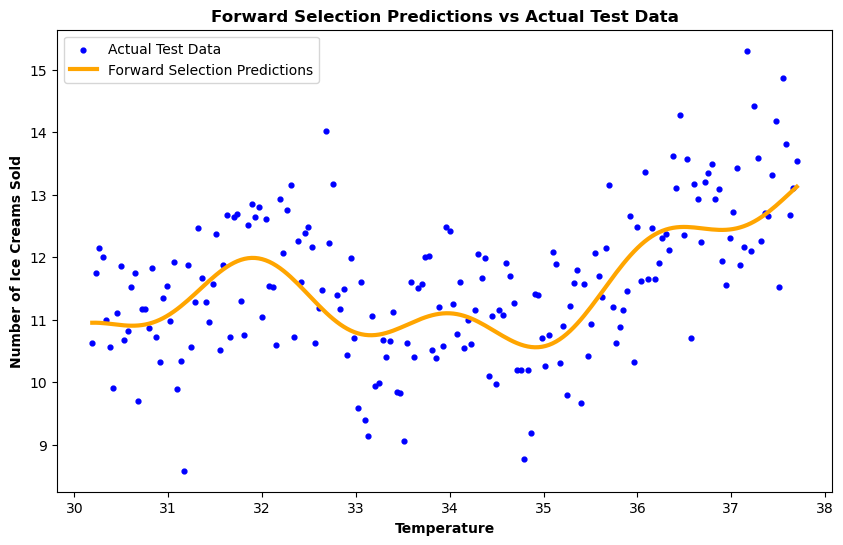


Lasso Regression on Test Data:
Mean Squared Error (MSE): 0.7890
R^2: 0.4203


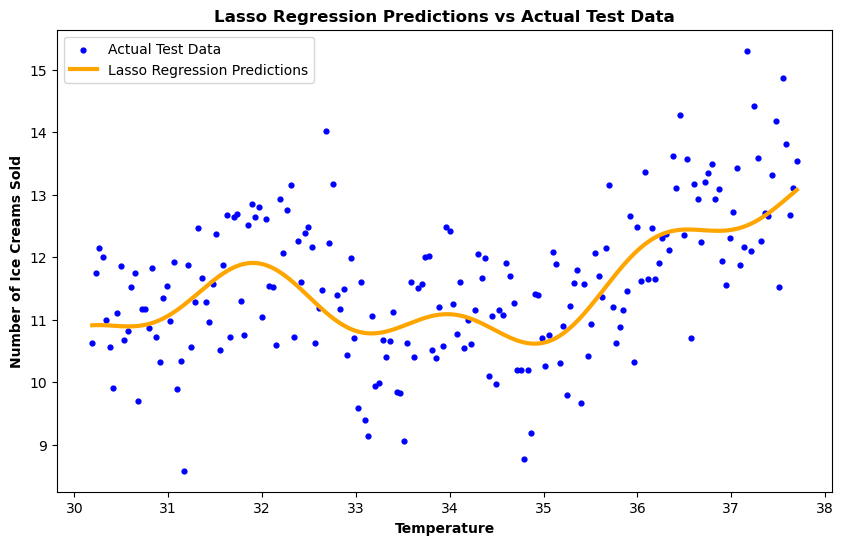


Ridge Regression on Test Data:
Mean Squared Error (MSE): 0.7797
R^2: 0.4271


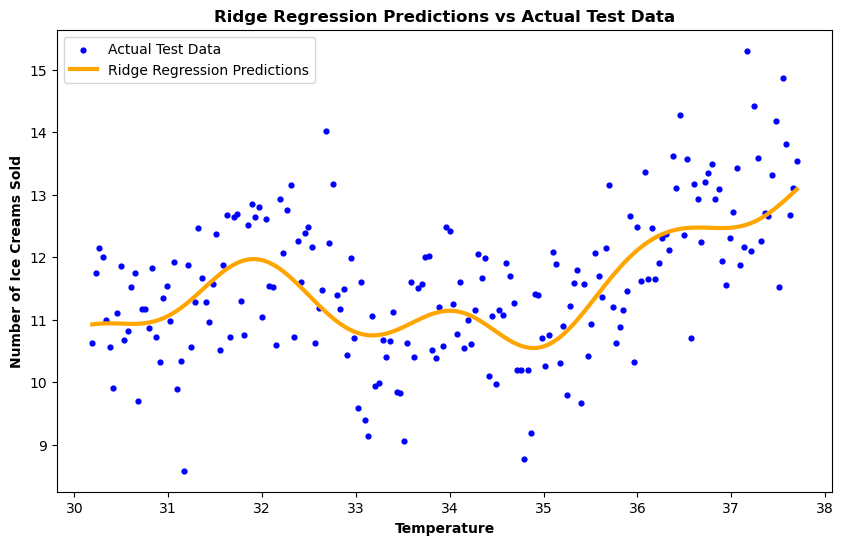

In [30]:
evaluate_on_test_data(test_df['Temperature'], y_test, model, X_test_selected, model_name="Forward Selection")
evaluate_on_test_data(test_df['Temperature'], y_test, lasso, X_test, model_name="Lasso Regression")
evaluate_on_test_data(test_df['Temperature'], y_test, ridge, X_test, model_name="Ridge Regression")